### This notebook is a clone of the "Predict who will move to a new job - Siti Khotijah" for my practice purposes(Code Analysis about Best Practice).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

In [4]:
ls

Clone__Predict_who_will_move_to_a_new_job.ipynb
HR_Analytics.ipynb
data/


### Training Data

In [5]:
train = pd.read_csv('./data/aug_train.csv')

In [6]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


### Features
* enrollee_id : Unique ID for enrollee
* city: City code
* citydevelopmentindex: Developement index of the city (scaled)
* gender: Gender of enrolee
* relevent_experience: Relevent experience of enrolee
* enrolled_university: Type of University course enrolled if any
* education_level: Education level of enrolee
* major_discipline :Education major discipline of enrolee
* experience: Enrolee total experience in years
* company_size: No of employees in current employer's company
* company_type : Type of current employer
* lastnewjob: Difference in years between previous job and current job
* training_hours: training hours completed
* target: 0 – Not looking for job change, 1 – Looking for a job change

### Visualization
Here I did compare the features that might influence the move to a new job and get the max, min and mean of the features

In [7]:
train.columns = train.columns.str.strip()

In [8]:
train['gender'].unique()

array(['Male', nan, 'Female', 'Other'], dtype=object)

In [9]:
train['education_level'].unique()

array(['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School'],
      dtype=object)

In [10]:
len(train.columns)

14

In [11]:
train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

실수) Groupby()에 포함되는 컬럼은 반드시 참조하는 선행 컬럼(Df)에 포함되어야 함.

In [12]:
display(train[['city','city_development_index','relevent_experience','gender','education_level','major_discipline','experience','company_size','company_type','target']].\
        groupby(['gender','education_level','experience','company_size'])\
        .agg(['max','mean','min'])\
        .style.background_gradient(cmap='Oranges'))

### Bar plots
showing the frequency of each category seperated by label

In [34]:
plt.style.use('dark_background')

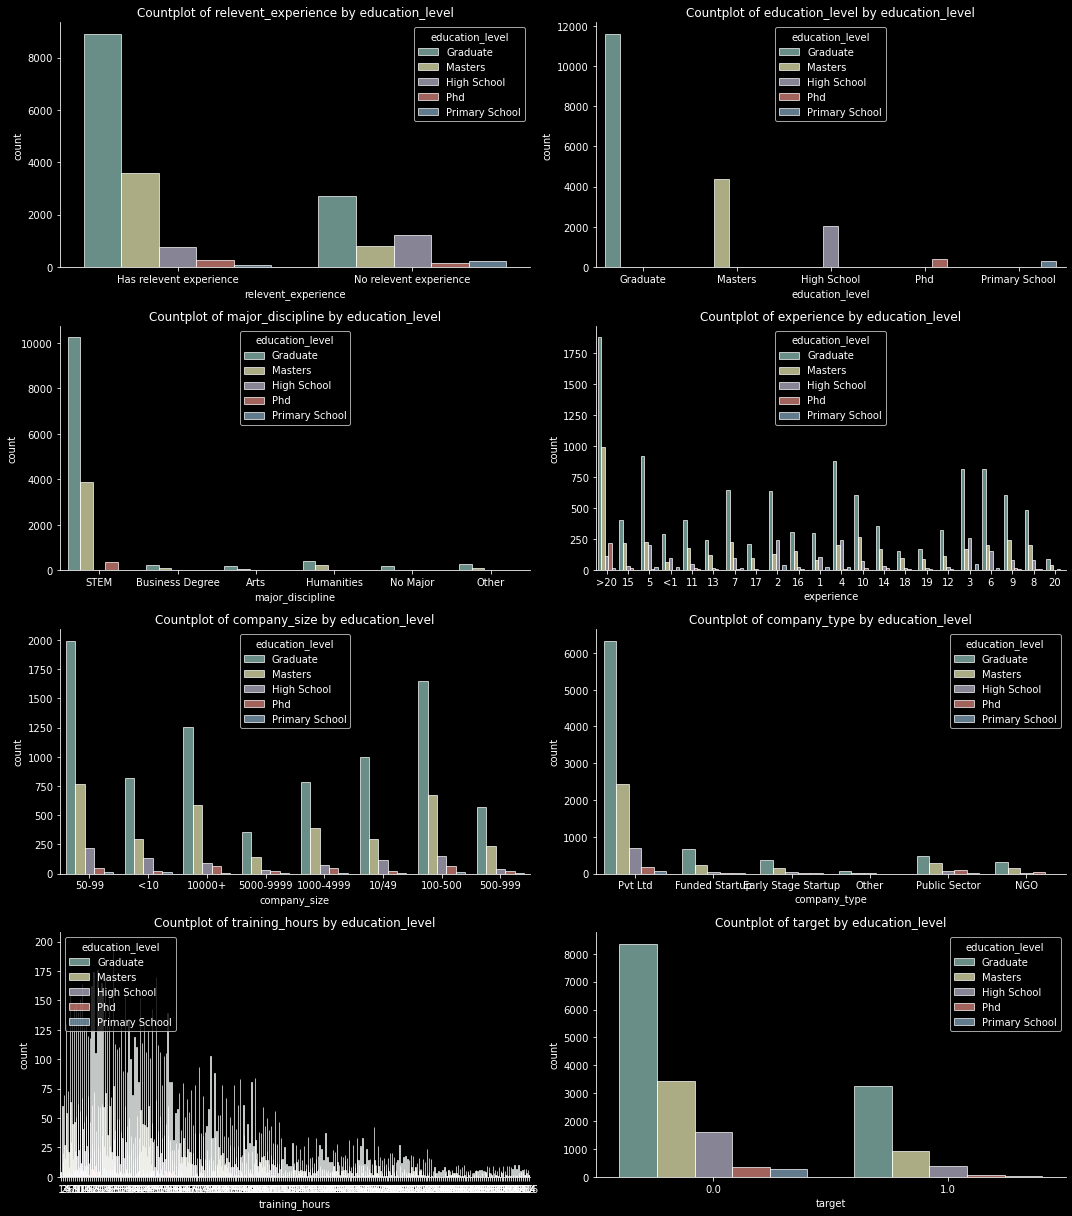

In [35]:
#barplots showing the frequency of each category separated by label
plt.figure(figsize=[15,17])
fft=['relevent_experience','education_level','major_discipline','experience','company_size','company_type','training_hours','target']
n=1
for f in fft:
    plt.subplot(4,2,n)
    sns.countplot(x=f, hue='education_level',edgecolor='white',alpha=0.7,data=train)
    sns.despine()
    plt.title('Countplot of {} by education_level'.format(f))
    n=n+1
plt.tight_layout()
plt.show()

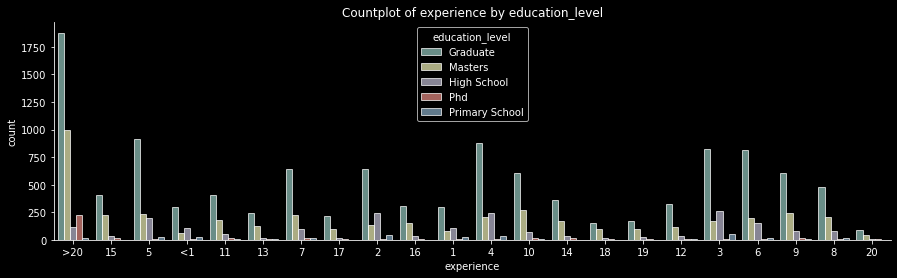

In [36]:
plt.figure(figsize=[15,4])
sns.countplot(x='experience', hue='education_level',edgecolor='white',alpha=0.7, data=train)
sns.despine()
plt.title('Countplot of experience by education_level')
plt.show()

sns.despine()은 테두리를 제거하는 메소드

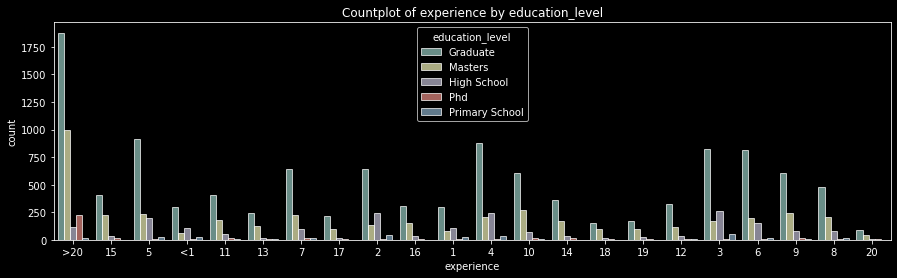

In [37]:
plt.figure(figsize=[15,4])
sns.countplot(x='experience', hue='education_level',edgecolor='white',alpha=0.7, data=train)
#sns.despine()
plt.title('Countplot of experience by education_level')
plt.show()

### Target
* 0 - Not Looking for a job change
* 1 - Looking for a job change

As you can see, here we have imbalanced data, the number of 1 (Looking for a job change) < 0 (Not Looking for a job change)

In [38]:
mnj = train['target'].value_counts()

In [39]:
mnj

0.0    14381
1.0     4777
Name: target, dtype: int64

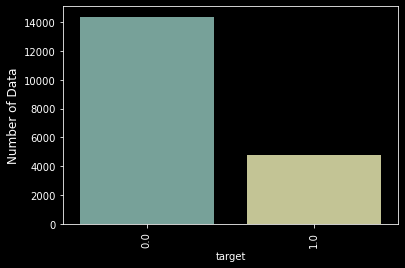

In [40]:
plt.figure(figsize=(6,4))
sns.barplot(mnj.index, mnj.values, alpha=0.8)
plt.ylabel('Number of Data', fontsize=12)
plt.xlabel('target',fontsize=10)
plt.xticks(rotation=90)
plt.show()

### Education Level
This dataset contains 5 education level:
* Graduate
* Masters
* High School
* PhD
* Primary School

In [41]:
EL = train['education_level'].value_counts()

In [42]:
EL

Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64

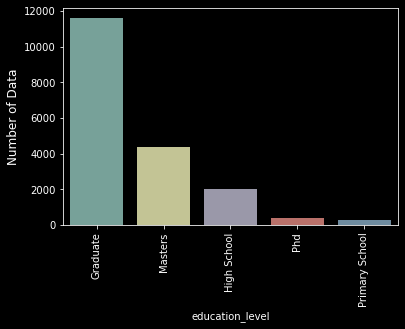

In [43]:
plt.figure(figsize=(6,4))
sns.barplot(EL.index, EL.values, alpha=0.8)
plt.ylabel('Number of Data', fontsize=12)
plt.xlabel('education_level',fontsize=10)
plt.xticks(rotation=90)
plt.show();

### Pie plot

In [44]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

In [45]:
train['education_level'].value_counts()

Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [46]:
train['education_level'].value_counts().index

Index(['Graduate', 'Masters', 'High School', 'Phd', 'Primary School'], dtype='object')

In [47]:
train['education_level'].value_counts().reset_index()

,index,education_level
0,Graduate,11598
1,Masters,4361
2,High School,2017
3,Phd,414
4,Primary School,308


In [48]:
train['education_level'].value_counts().reset_index().index

RangeIndex(start=0, stop=5, step=1)

In [49]:
el = train['education_level'].value_counts().reset_index()

In [50]:
el.columns

Index(['index', 'education_level'], dtype='object')

In [51]:
el.columns = ['education_level','percent']

In [52]:
el['percent'] /= len(train)

In [53]:
el

,education_level,percent
0,Graduate,0.605387
1,Masters,0.227633
2,High School,0.105282
3,Phd,0.021610
4,Primary School,0.016077


In [54]:
el

,education_level,percent
0,Graduate,0.605387
1,Masters,0.227633
2,High School,0.105282
3,Phd,0.021610
4,Primary School,0.016077


**jupyter labextension install jupyterlab-plotly**

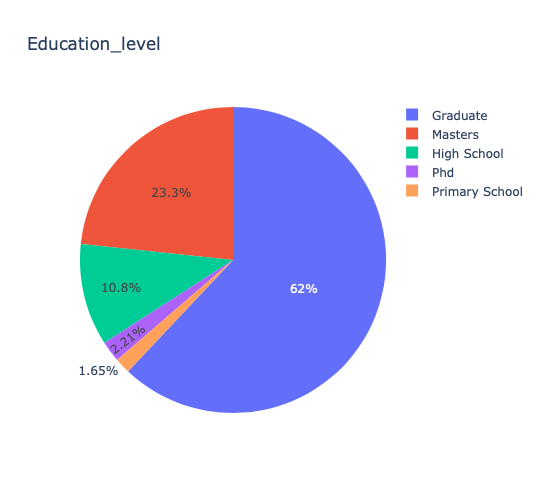

In [65]:
fig = px.pie(
    el, 
    names='education_level', 
    values='percent', 
    title='Education_level', 
    width=800,
    height=500
)
#color - dark_mode
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

### Education_level : training_hours

In [66]:
train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


In [69]:
train.sort_values(by='training_hours',ascending=True)[:7000].tail()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1867,14572,city_21,0.624,Male,Has relevent experience,no_enrollment,Masters,STEM,8,50-99,Public Sector,4,33,1.0
2144,10937,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,1000-4999,Public Sector,>4,33,0.0
17405,29082,city_114,0.926,Male,No relevent experience,Full time course,High School,NaN,7,500-999,Pvt Ltd,1,33,0.0
9132,53,city_16,0.910,NaN,No relevent experience,Full time course,High School,NaN,7,NaN,Pvt Ltd,never,33,0.0
6882,9783,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,1000-4999,Pvt Ltd,>4,33,0.0


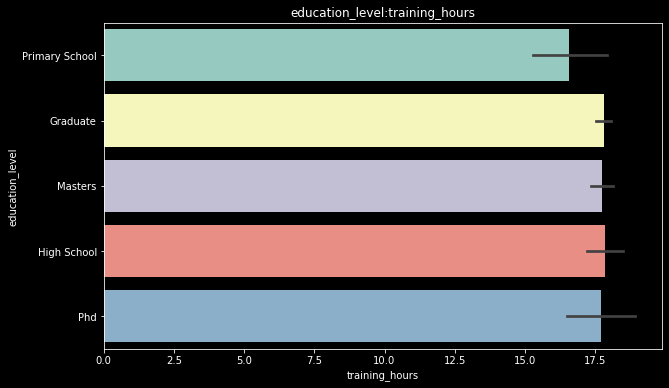

In [71]:
#training_hours 1~33시간까지만 추출
et = train.sort_values(by='training_hours',ascending=True)[:7000]
figure = plt.figure(figsize=(10,6))
sns.barplot(y=et.education_level, x=et.training_hours)
plt.xticks()
plt.xlabel('training_hours')
plt.ylabel('education_level')
plt.title('education_level:training_hours')
plt.show()

### City development index
The City Development Index was developed for the Second United Nations Conference on Human Settlements (Habitat II) in 1996 and measures the level of development in cities. The Urban Indicators Programme of the United Nations Human Settlements Programme (UN-Habitat) developed the indicator so that they could rank cities of the world according to their level of development and as a display of indicators depicting development. The CDI cuts across the different clusters identified in the Urban Indicator Framework as it is based on five sub indices namely, infrastructure, waste, health, education and city product. It is useful as it provides a snap-shot view of how cities are doing with respect to the different indices. It was invented by Dr Joe Flood, first Coordinator of the Urban Indicators Program, following a statistical analysis of city indicators data. Reference :https://en.wikipedia.org/wiki/City_development_index

In [72]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

In [74]:
train['city_development_index']

0        0.920
1        0.776
2        0.624
3        0.789
4        0.767
         ...  
19153    0.878
19154    0.920
19155    0.920
19156    0.802
19157    0.855
Name: city_development_index, Length: 19158, dtype: float64

In [75]:
train['city_development_index'].value_counts()

0.920    5200
0.624    2702
0.910    1533
0.926    1336
0.698     683
         ... 
0.649       4
0.807       4
0.781       3
0.625       3
0.664       1
Name: city_development_index, Length: 93, dtype: int64

In [76]:
train['city_development_index'].value_counts().reset_index()

,index,city_development_index
0,0.920,5200
1,0.624,2702
2,0.910,1533
3,0.926,1336
4,0.698,683
...,...,...
88,0.649,4
89,0.807,4
90,0.781,3
91,0.625,3


In [77]:
cdi = train['city_development_index'].value_counts().reset_index()
cdi.columns = [
    'city_development_index',
    'count'
]

In [79]:
cdi['city_development_index'] = cdi['city_development_index'].\
    astype(str) + '-'
cdi = cdi.sort_values(['count']).tail(50)

In [80]:
cdi

,city_development_index,count
49,0.691-,45
48,0.848-,47
47,0.7659999999999999-,49
46,0.727-,53
45,0.789-,54
44,0.555-,63
43,0.74-,67
42,0.5579999999999999-,75
41,0.738-,79
40,0.949-,79


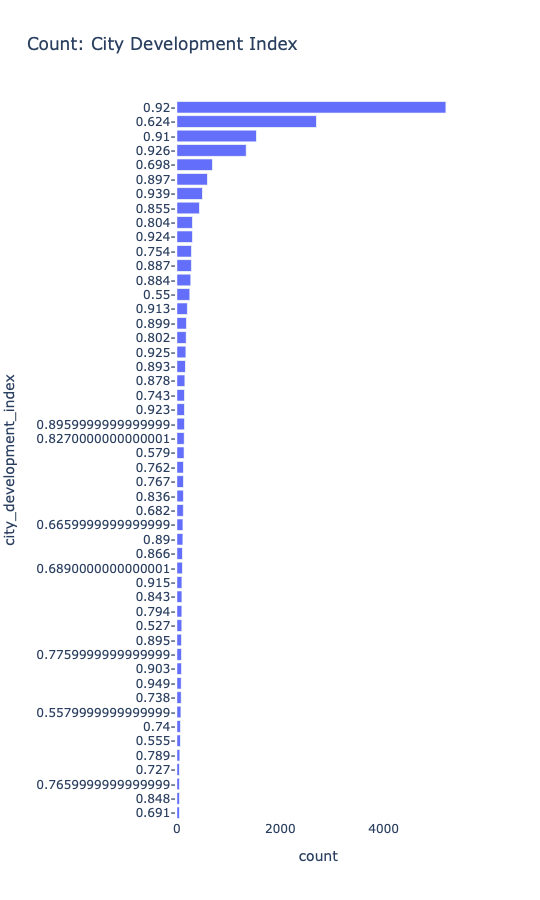

In [86]:
fig = px.bar(
    cdi,
    x='count',
    y='city_development_index',
    orientation='h',
    title='Count: City Development Index',
    width=1000,
    height=900
)
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

### City : City development index

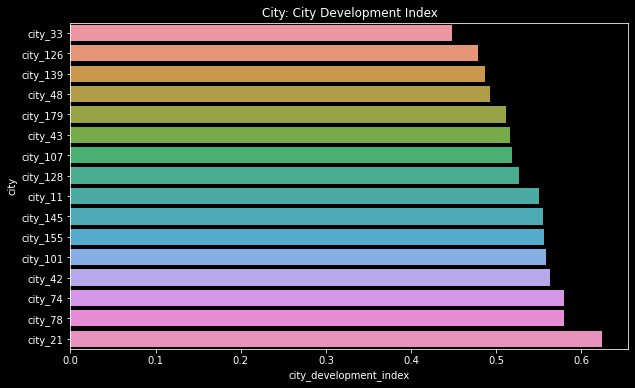

In [87]:
cdi_city = train.sort_values(by='city_development_index', ascending=True)[:2000]
#figure = plt.figure(figsize=(10,6))
plt.figure(figsize=(10,6))
sns.barplot(y=cdi_city.city, x=cdi_city.city_development_index)
plt.xticks()
plt.xlabel('city_development_index')
plt.ylabel('city')
plt.title('City: City Development Index')
plt.show()

Text(0.5, 1.0, 'Distributional of City Development Index')

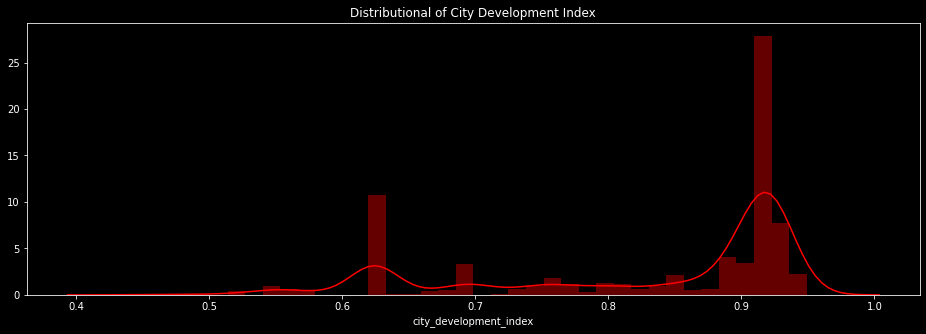

In [88]:
f, axes = plt.subplots(1,1,figsize=(16,5))
g1 = sns.distplot(train['city_development_index'],color='red',ax=axes)
plt.title('Distributional of City Development Index')

Text(0.5, 1.0, 'Distributional of City Development Index')

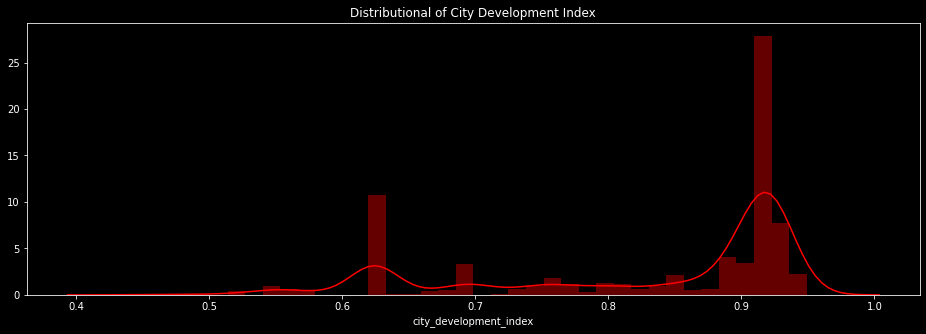

In [90]:
# 같은 코드
plt.figure(figsize=(16,5))
sns.distplot(train['city_development_index'],color='red')
plt.title('Distributional of City Development Index')

### Experience
Enrolee total experience in years

In [91]:
ep = train['experience'].value_counts().reset_index()
ep.columns = [
    'experience',
    'percent'
]
ep['percent'] /= len(train)

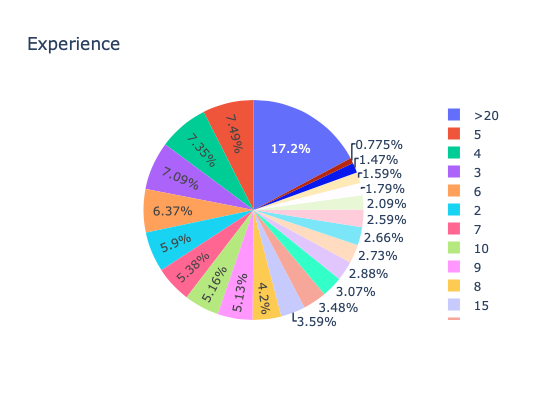

In [95]:
fig = px.pie(
    ep,
    names='experience',
    values='percent',
    title='Experience',
    width=700,
    height=400
)
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

### Training_hours

Text(0.5, 1.0, 'Distributional of Training Hours')

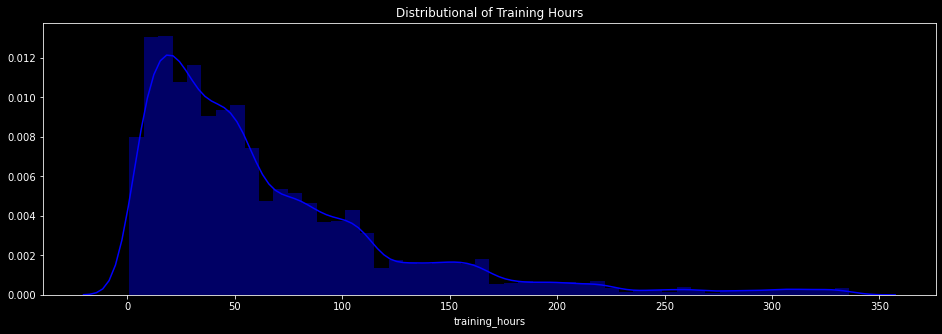

In [96]:
f, axes = plt.subplots(1,1,figsize=(16,5))
g1 = sns.distplot(train['training_hours'], color='blue', ax=axes)
plt.title('Distributional of Training Hours')

Text(0.5, 1.0, 'Distributional of Training Hours')

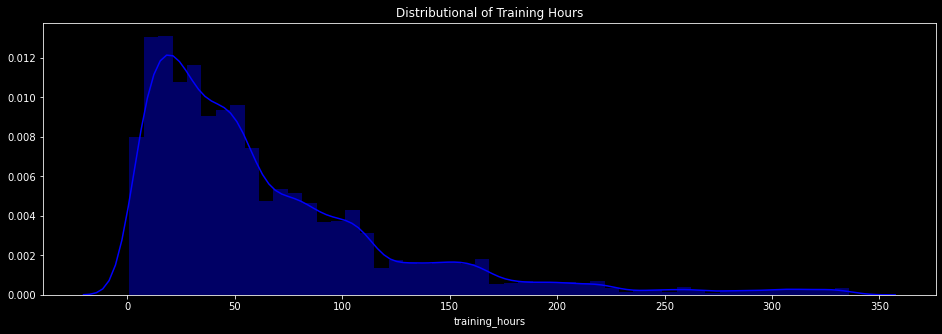

In [97]:
plt.figure(figsize=(16,5))
sns.distplot(train['training_hours'],color='blue')
plt.title('Distributional of Training Hours')

In [98]:
train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


Let's Check featrues that might influence

In [99]:
train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [101]:
train[['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target']]\
    [train['education_level']=='Graduate']

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
5,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19151,11385,city_149,0.689,Male,No relevent experience,Full time course,Graduate,NaN,2,NaN,NaN,1,60,0.0
19152,29754,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,Humanities,7,10/49,Funded Startup,1,25,0.0
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0


In [102]:
def wmnj(x):
    y = train[['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target']]\
    [train['education_level']==x]
    y = y.sort_values(by='enrollee_id',ascending=False)
    return y.head(15)

### Graduate

Start from graduate, here I found :

If **city_103** --> city_development_index: **0.920** --> the gender is male --> has relevent experience and experience **> 20** --> move to new job (1)
If **city_21** --> city_development_index: **0.624** --> the gender is male --> has relevent experience and experience **4** --> move to new job (1)
If **city_19** --> city_development_index: **0.682** --> the gender is male --> has relevent experience and experience **6** --> move to new job (1)

In [104]:
train['education_level'].unique()

array(['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School'],
      dtype=object)

In [103]:
wmnj('Graduate')

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1663,33380,city_83,0.923,Male,No relevent experience,no_enrollment,Graduate,STEM,14,10000+,Pvt Ltd,2,168,0.0
4756,33379,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,18,<10,Pvt Ltd,2,81,0.0
3351,33377,city_65,0.802,Male,Has relevent experience,no_enrollment,Graduate,Other,10,100-500,Pvt Ltd,2,27,0.0
17935,33375,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,16,50-99,Public Sector,1,51,0.0
8842,33368,city_61,0.913,NaN,Has relevent experience,no_enrollment,Graduate,STEM,14,100-500,Pvt Ltd,3,154,0.0
486,33367,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,>4,220,1.0
15902,33365,city_104,0.924,Male,Has relevent experience,no_enrollment,Graduate,STEM,11,<10,Early Stage Startup,1,84,0.0
18439,33362,city_173,0.878,Male,Has relevent experience,no_enrollment,Graduate,STEM,16,10000+,Pvt Ltd,1,100,0.0
2276,33357,city_16,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,4,100-500,Pvt Ltd,1,18,0.0
7437,33356,city_90,0.698,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,100-500,Pvt Ltd,>4,51,0.0


### Masters

Here I found :

If city_136 --> city_development_index: 0.897 --> the gender is male --> has relevent experience and experience 6 --> move to new job (1)

If city_103 --> city_development_index: 0.920 --> the gender is male --> has relevent experience and experience 17 --> move to new job (1)

If city_159 --> city_development_index: 0.843 --> the gender is male --> has relevent experience and experience 7 --> move to new job (1)

If city_50 --> city_development_index: 0.896 --> the gender is male --> has relevent experience and experience 10 --> move to new job (1)

If city_106 --> city_development_index: 0.698 --> the gender is male --> has relevent experience and experience 8 --> move to new job (1)

If city_21 --> city_development_index: 0.624 --> the gender is male --> has relevent experience and experience 14 --> move to new job (1)

The last one is different from other

city_21 --> city_development_index: 0.624 --> the gender is male --> No relevent experience and experience 2 --> move to new job (1)

In [105]:
wmnj('Masters')

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
5009,33376,city_16,0.910,Female,Has relevent experience,no_enrollment,Masters,Business Degree,8,1000-4999,Public Sector,4,74,0.0
6947,33373,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,6,100-500,Public Sector,2,34,1.0
2019,33360,city_103,0.920,Male,Has relevent experience,no_enrollment,Masters,STEM,17,NaN,NaN,>4,65,1.0
802,33358,city_159,0.843,Female,Has relevent experience,no_enrollment,Masters,STEM,7,50-99,Pvt Ltd,1,6,1.0
7530,33348,city_21,0.624,Male,No relevent experience,Part time course,Masters,STEM,15,100-500,Pvt Ltd,never,9,0.0
15711,33325,city_103,0.920,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Public Sector,1,102,0.0
5475,33307,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,7,100-500,Pvt Ltd,4,45,0.0
11352,33306,city_50,0.896,Male,No relevent experience,Full time course,Masters,STEM,10,NaN,NaN,4,34,1.0
1270,33304,city_106,0.698,Male,Has relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,1,23,1.0
16219,33301,city_21,0.624,Male,Has relevent experience,no_enrollment,Masters,STEM,14,10/49,NGO,2,268,1.0


### High School

Here I found :

If city_99 --> city_development_index: 0.915 --> the gender is male --> has relevent experience and experience 14 --> move to new job (1)

If city_100 --> city_development_index: 0.887 --> the gender is male --> has relevent experience and experience >20 --> move to new job (1)

If city_160 --> city_development_index: 0.920 --> the gender is male --> has relevent experience and experience 9 --> move to new job (1)

If city_73 --> city_development_index: 0.754 --> the gender is male --> has relevent experience and experience 3 --> move to new job (1)

If city_21 --> city_development_index: 0.624 --> the gender is male --> has relevent experience and experience 4 --> move to new job (1)

In [106]:
wmnj('High School')

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
4813,33370,city_114,0.926,Male,No relevent experience,Full time course,High School,NaN,6,NaN,NaN,1,264,0.0
690,33342,city_21,0.624,Male,No relevent experience,Full time course,High School,NaN,5,NaN,Pvt Ltd,never,6,0.0
14491,33341,city_75,0.939,Male,Has relevent experience,Full time course,High School,NaN,6,50-99,Pvt Ltd,1,28,0.0
17390,33335,city_99,0.915,Male,Has relevent experience,no_enrollment,High School,NaN,14,1000-4999,Pvt Ltd,1,6,1.0
8828,33317,city_61,0.913,Male,No relevent experience,no_enrollment,High School,NaN,2,NaN,NaN,2,258,0.0
14004,33273,city_102,0.804,Male,Has relevent experience,Part time course,High School,NaN,17,50-99,Pvt Ltd,4,20,0.0
12927,33271,city_100,0.887,Male,Has relevent experience,no_enrollment,High School,NaN,>20,NaN,NaN,1,102,1.0
7535,33261,city_160,0.920,Male,No relevent experience,Full time course,High School,NaN,9,NaN,NaN,4,44,1.0
18985,33253,city_41,0.827,Male,Has relevent experience,no_enrollment,High School,NaN,18,NaN,NaN,>4,12,0.0
17876,33249,city_73,0.754,Male,No relevent experience,Part time course,High School,NaN,3,NaN,NaN,1,60,1.0


In [115]:
train[train['city']=='city_99'][['experience','target']].sort_values(by='experience')[:50]

,experience,target
15684,1,0.0
9432,10,0.0
16640,10,0.0
1382,10,0.0
8736,10,0.0
8676,10,0.0
5292,10,0.0
12957,11,0.0
7893,12,0.0
7242,12,0.0


### PhD


Here I found :

If city_42 --> city_development_index: 0.563 --> the gender is male --> has relevent experience and experience < 1 --> move to new job (1)

If city_103 --> city_development_index: 0.920 --> the gender is male --> No relevent experience and experience > 20 --> move to new job (1)

If city_16 --> city_development_index: 0.910 --> the gender is female --> has relevent experience and experience 9 --> move to new job (1)

In [118]:
wmnj('Phd')

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
7526,33352,city_16,0.910,Female,Has relevent experience,no_enrollment,Phd,STEM,>20,100-500,Pvt Ltd,1,91,0.0
17102,33311,city_136,0.897,Male,Has relevent experience,no_enrollment,Phd,STEM,>20,100-500,Public Sector,>4,55,0.0
14237,33193,city_114,0.926,Male,No relevent experience,no_enrollment,Phd,STEM,>20,NaN,NaN,>4,24,0.0
16483,32982,city_75,0.939,Male,Has relevent experience,no_enrollment,Phd,STEM,14,<10,Early Stage Startup,1,117,0.0
18458,32716,city_103,0.920,NaN,Has relevent experience,no_enrollment,Phd,STEM,17,50-99,Pvt Ltd,1,336,0.0
11677,32687,city_42,0.563,NaN,Has relevent experience,Full time course,Phd,STEM,<1,NaN,NaN,NaN,43,1.0
1013,32631,city_103,0.920,Male,Has relevent experience,no_enrollment,Phd,STEM,>20,1000-4999,Public Sector,>4,5,1.0
932,32427,city_103,0.920,Male,Has relevent experience,no_enrollment,Phd,STEM,9,1000-4999,Public Sector,1,131,0.0
12557,32251,city_67,0.855,Male,No relevent experience,no_enrollment,Phd,STEM,>20,NaN,Public Sector,>4,99,0.0
3853,32246,city_94,0.698,Male,Has relevent experience,no_enrollment,Phd,STEM,>20,50-99,Pvt Ltd,>4,7,0.0


### Primary School

Here I found :

If city_70 --> city_development_index: 0.698 --> the gender is male --> No relevent experience and experience < 1 --> move to new job (1)

If city_103 --> city_development_index: 0.920 --> the gender is other --> No relevent experience and experience 3 --> move to new job (1)

If city_103 --> city_development_index: 0.920 --> the gender is female --> No relevent experience and experience 2 --> move to new job (1)

If city_126 --> city_development_index: 0.479 --> the gender is female --> Has relevent experience and experience 19 --> move to new job (1)

In [119]:
wmnj('Primary School')

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
16336,33147,city_103,0.920,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,NaN,never,198,0.0
7496,32801,city_103,0.920,Other,No relevent experience,no_enrollment,Primary School,NaN,4,NaN,NaN,never,5,0.0
12433,32639,city_160,0.920,Male,No relevent experience,no_enrollment,Primary School,NaN,1,NaN,NaN,never,22,0.0
1619,32615,city_160,0.920,Male,No relevent experience,no_enrollment,Primary School,NaN,<1,1000-4999,Public Sector,2,85,0.0
11622,32413,city_93,0.865,Male,No relevent experience,no_enrollment,Primary School,NaN,5,50-99,NaN,never,40,0.0
8159,32408,city_103,0.920,Male,No relevent experience,no_enrollment,Primary School,NaN,5,NaN,Pvt Ltd,never,25,0.0
11928,32357,city_70,0.698,Female,No relevent experience,Full time course,Primary School,NaN,<1,NaN,Pvt Ltd,never,37,1.0
13438,32294,city_103,0.920,Other,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,NaN,never,136,1.0
8415,32277,city_9,0.743,Male,No relevent experience,Part time course,Primary School,NaN,2,<10,Early Stage Startup,never,48,0.0
10064,32238,city_159,0.843,Male,No relevent experience,Full time course,Primary School,NaN,8,NaN,NaN,1,162,0.0


### Correlation in Data

Here I try to measure correlation in data using Correlation coefficients.

Correlation coefficientsare used to measure how strong a relationship is between two variables.Correlation coefficient formulas are used to find how strong a relationship is between data. The formulas return a value between -1 and 1, where:

1 indicates a strong positive relationship.
-1 indicates a strong negative relationship.
A result of zero indicates no relationship at all.
![hello](https://www.statisticshowto.com/wp-content/uploads/2012/10/pearson-2-small.png)
reference : https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/#Pearson

In [122]:
train.corr()

,enrollee_id,city_development_index,training_hours,target
enrollee_id,1.000000,-0.040455,0.000998,0.049475
city_development_index,-0.040455,1.000000,0.001920,-0.341665
training_hours,0.000998,0.001920,1.000000,-0.021577
target,0.049475,-0.341665,-0.021577,1.000000


In [121]:
train.corr()['target']

enrollee_id               0.049475
city_development_index   -0.341665
training_hours           -0.021577
target                    1.000000
Name: target, dtype: float64

In [123]:
corr = train.corr()['target']

In [125]:
corr[np.argsort(corr, axis=0)][:-1]

city_development_index   -0.341665
training_hours           -0.021577
enrollee_id               0.049475
Name: target, dtype: float64

### Plotting correlations

In [126]:
train['training_hours'].values

array([ 36,  47,  83, ...,  44,  97, 127])

In [127]:
train['target'].values

array([1., 0., 0., ..., 0., 0., 0.])

In [128]:
np.corrcoef(train['training_hours'].values, train['target'].values)

array([[ 1.        , -0.02157725],
       [-0.02157725,  1.        ]])

In [129]:
np.corrcoef(train['training_hours'].values, train['target'].values)[0,1]

-0.021577249713613304

In [130]:
# plotting correlations
num_feat = train.columns[train.dtypes!=object]
num_feat = num_feat[:-1]
labels = []
values = []
for col in num_feat:
    labels.append(col)
    values.append(np.corrcoef(train[col].values, train.target.values)[0,1])

In [131]:
labels

['enrollee_id', 'city_development_index', 'training_hours']

In [132]:
values

[0.0494747625973025, -0.3416650855452297, -0.021577249713613304]

In [133]:
len(labels)

3

In [134]:
np.arange(len(labels))

array([0, 1, 2])

In [139]:
np.array(values)

array([ 0.04947476, -0.34166509, -0.02157725])

Text(0.5, 1.0, 'Correlation Coefficients each feature with target')

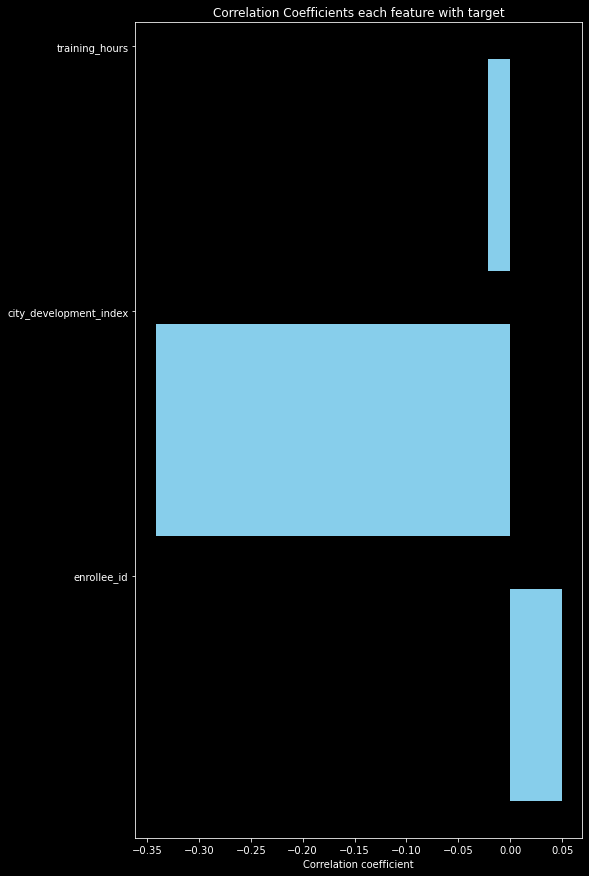

In [141]:
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(8,15))
rects = ax.barh(ind, np.array(values), color='skyblue')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation Coefficients each feature with target")

### Heatmap

In [142]:
train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [143]:
corrMatrix = train[['city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target']].corr()

In [144]:
corrMatrix

,city_development_index,training_hours,target
city_development_index,1.000000,0.001920,-0.341665
training_hours,0.001920,1.000000,-0.021577
target,-0.341665,-0.021577,1.000000


숫자형 컬럼만 corr 적용가능

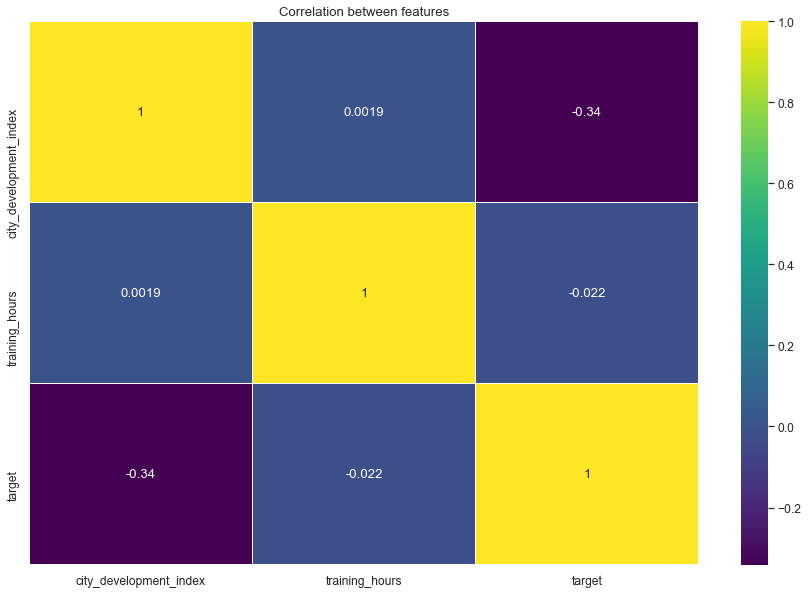

In [146]:
sns.set(font_scale=1.10)
plt.figure(figsize=(15,10))
sns.heatmap(corrMatrix, linewidths=0.01, square=False, annot=True,
           cmap='viridis',linecolor='white')
plt.title('Correlation between features');

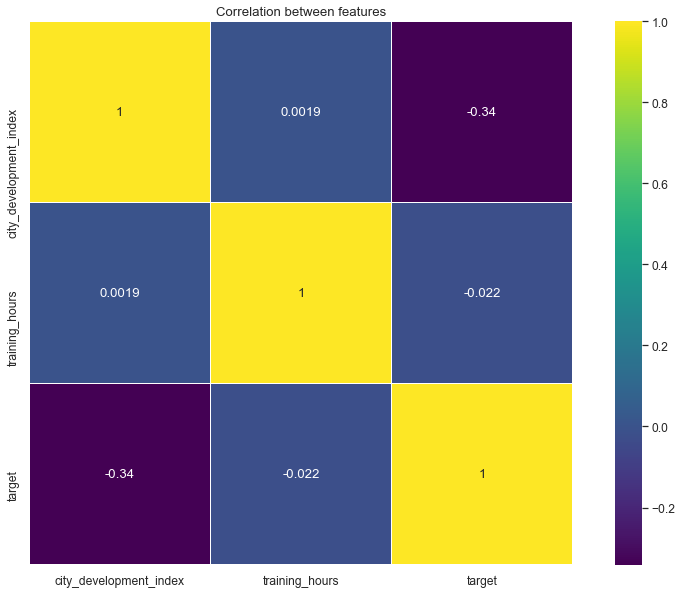

In [148]:
# square True로 적용, 각 cell이 정사각형
sns.set(font_scale=1.10)
plt.figure(figsize=(15,10))
sns.heatmap(corrMatrix, linewidths=0.01, square=True, annot=True,
           cmap='viridis',linecolor='white')
plt.title('Correlation between features');

### Preprocessing

Here I creating a function that converts all values of gender and etc below into numbers (category)
* ['gender'], ['relevent_experience'], ['enrolled_university'],
* ['education_level'], ['major_discipline'], ['experience'], ['company_type'], 
* ['company_size'], ['last_new_job'], ['city']

In [149]:
# Creating a function that converts all values of , ['gender'], ['relevent_experience'] , ['enrolled_university'],
# , ['education_level'], ['major_discipline'], ['experience'], ['company_type'],  ['company_size']
# , ['last_new_job'], ['city'] into numbers

#### 1. Gender

In [151]:
train['gender'].unique()

array(['Male', nan, 'Female', 'Other'], dtype=object)

In [152]:
def gender_to_numeric(x):
    if x=='Female': return 2
    if x=='Male': return 1
    if x=='Other': return 0

#### 2. Relevent Experience

In [157]:
train['relevent_experience'].unique()

array(['Has relevent experience', 'No relevent experience'], dtype=object)

In [158]:
def rel_experience(x):
    if x=='Has relevent experience': return 1
    if x=='No relevent experience': return 0

#### 3. Enrolled University

In [160]:
train['enrolled_university'].unique()

array(['no_enrollment', 'Full time course', nan, 'Part time course'],
      dtype=object)

In [161]:
def enrollment(x):
    if x=='no_enrollment': return 0
    if x=='Full time course': return 1
    if x=='Part time course': return 2

#### 4. Education Level

In [162]:
train['education_level'].unique()

array(['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School'],
      dtype=object)

In [163]:
def edu_level(x):
    if x=='Graduate': return 0
    if x=='Masters': return 1
    if x=='High School': return 2
    if x=='Phd': return 3
    if x=='Primary School': return 4

#### 5. Major

In [164]:
train['major_discipline'].unique()

array(['STEM', 'Business Degree', nan, 'Arts', 'Humanities', 'No Major',
       'Other'], dtype=object)

In [165]:
def major(x):
    if x=='STEM': return 0
    if x=='Business Degree': return 1
    if x=='Arts': return 2
    if x=='Humanities': return 3
    if x=='No Major': return 4
    if x=='Other': return 5

#### 5. Experience

In [166]:
train['experience'].unique()

array(['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4',
       '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan],
      dtype=object)

In [167]:
def experience(x):
    if x=='<1'      :   return 0
    if x=='1'       :   return 1 
    if x=='2'       :   return 2 
    if x=='3'       :   return 3 
    if x=='4'       :   return 4 
    if x=='5'       :   return 5
    if x=='6'       :   return 6
    if x=='7'       :   return 7
    if x=='8'       :   return 8 
    if x=='9'       :   return 9 
    if x=='10'      :   return 10 
    if x=='11'      :   return 11
    if x=='12'      :   return 12
    if x=='13'      :   return 13 
    if x=='14'      :   return 14 
    if x=='15'      :   return 15 
    if x=='16'      :   return 16
    if x=='17'      :   return 17
    if x=='18'      :   return 18
    if x=='19'      :   return 19 
    if x=='20'      :   return 20 
    if x=='>20'     :   return 21 

#### 6. Company type

In [168]:
train['company_type'].unique()

array([nan, 'Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Other',
       'Public Sector', 'NGO'], dtype=object)

In [169]:
def company_t(x):
    if x=='Pvt Ltd': return 0
    if x=='Funded Startup': return 1
    if x=='Early Stage Startup': return 2
    if x=='Other': return 3
    if x=='Public Sector': return 4
    if x=='NGO': return 5

#### 7. Company size

In [170]:
train['company_size'].unique()

array([nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49',
       '100-500', '500-999'], dtype=object)

In [171]:
def company_s(x):
    if x=='<10'          :   return 0
    if x=='10/49'        :   return 1 
    if x=='100-500'      :   return 2 
    if x=='1000-4999'    :   return 3 
    if x=='10000+'       :   return 4 
    if x=='50-99'        :   return 5 
    if x=='500-999'      :   return 6 
    if x=='5000-9999'    :   return 7
    

#### 8. Last Job

In [172]:
train['last_new_job'].unique()

array(['1', '>4', 'never', '4', '3', '2', nan], dtype=object)

In [173]:
def last_job(x):
    if x=='never'        :   return 0
    if x=='1'            :   return 1 
    if x=='2'            :   return 2 
    if x=='3'            :   return 3 
    if x=='4'            :   return 4 
    if x=='>4'           :   return 5 

#### 9. City

In [174]:
train['city'].unique()

array(['city_103', 'city_40', 'city_21', 'city_115', 'city_162',
       'city_176', 'city_160', 'city_46', 'city_61', 'city_114',
       'city_13', 'city_159', 'city_102', 'city_67', 'city_100',
       'city_16', 'city_71', 'city_104', 'city_64', 'city_101', 'city_83',
       'city_105', 'city_73', 'city_75', 'city_41', 'city_11', 'city_93',
       'city_90', 'city_36', 'city_20', 'city_57', 'city_152', 'city_19',
       'city_65', 'city_74', 'city_173', 'city_136', 'city_98', 'city_97',
       'city_50', 'city_138', 'city_82', 'city_157', 'city_89',
       'city_150', 'city_70', 'city_175', 'city_94', 'city_28', 'city_59',
       'city_165', 'city_145', 'city_142', 'city_26', 'city_12',
       'city_37', 'city_43', 'city_116', 'city_23', 'city_99', 'city_149',
       'city_10', 'city_45', 'city_80', 'city_128', 'city_158',
       'city_123', 'city_7', 'city_72', 'city_106', 'city_143', 'city_78',
       'city_109', 'city_24', 'city_134', 'city_48', 'city_144',
       'city_91', 'city_

In [175]:
def city(x):
    if x=='city_103'         : return  0
    if x=='city_40'          : return  1
    if x=='city_21'          : return  2
    if x=='city_115'         : return  3
    if x=='city_162'         : return  4
    if x=='city_176'         : return  5
    if x=='city_160'         : return  6
    if x=='city_46'          : return  7
    if x=='city_61'          : return  8
    if x=='city_114'         : return  9
    if x=='city_13'          : return  10
    if x=='city_159'         : return  11
    if x=='city_102'         : return  12
    if x=='city_67'          : return  13
    if x=='city_100'         : return  14
    if x=='city_16'          : return  15
    if x=='city_71'          : return  16
    if x=='city_104'         : return  17
    if x=='city_64'          : return  18
    if x=='city_101'         : return  19
    if x=='city_83'          : return  20
    if x=='city_105'         : return  21
    if x=='city_73'          : return  22
    if x=='city_75'          : return  23
    if x=='city_41'          : return  24
    if x=='city_11'          : return  25
    if x=='city_93'          : return  26
    if x=='city_90'          : return  27
    if x=='city_36'          : return  28
    if x=='city_20'          : return  29
    if x=='city_57'          : return  30
    if x=='city_152'         : return  31
    if x=='city_19'          : return  32
    if x=='city_65'          : return  33
    if x=='city_74'          : return  34
    if x=='city_173'         : return  35
    if x=='city_136'         : return  36
    if x=='city_98'          : return  37
    if x=='city_97'          : return  38
    if x=='city_50'          : return  39
    if x=='city_138'         : return  40
    if x=='city_82'          : return  41
    if x=='city_157'         : return  42
    if x=='city_89'          : return  43
    if x=='city_150'         : return  44
    if x=='city_70'          : return  45
    if x=='city_175'         : return  46
    if x=='city_94'          : return  47
    if x=='city_28'          : return  48
    if x=='city_59'          : return  49
    if x=='city_165'         : return  50
    if x=='city_145'         : return  51
    if x=='city_142'         : return  52
    if x=='city_26'          : return  53
    if x=='city_12'          : return  54
    if x=='city_37'          : return  55
    if x=='city_43'          : return  56
    if x=='city_116'         : return  57
    if x=='city_23'          : return  58
    if x=='city_99'          : return  59
    if x=='city_149'         : return  60
    if x=='city_10'          : return  61
    if x=='city_45'          : return  62
    if x=='city_80'          : return  63
    if x=='city_128'         : return  64
    if x=='city_158'         : return  65
    if x=='city_123'         : return  66
    if x=='city_7'           : return  67
    if x=='city_72'          : return  68
    if x=='city_106'         : return  69
    if x=='city_143'         : return  70
    if x=='city_78'          : return  71
    if x=='city_109'         : return  72
    if x=='city_24'          : return  73
    if x=='city_134'         : return  74
    if x=='city_48'          : return  75
    if x=='city_144'         : return  76
    if x=='city_91'          : return  77
    if x=='city_146'         : return  78
    if x=='city_133'         : return  79
    if x=='city_126'         : return  80
    if x=='city_118'         : return  81
    if x=='city_9'           : return  82
    if x=='city_167'         : return  83
    if x=='city_27'          : return  84
    if x=='city_84'          : return  85
    if x=='city_54'          : return  86
    if x=='city_39'          : return  87
    if x=='city_79'          : return  88
    if x=='city_76'          : return  89
    if x=='city_77'          : return  90
    if x=='city_81'          : return  91
    if x=='city_131'         : return  92
    if x=='city_44'          : return  93
    if x=='city_117'         : return  94
    if x=='city_155'         : return  95
    if x=='city_33'          : return  96
    if x=='city_141'         : return  97
    if x=='city_127'         : return  98
    if x=='city_62'          : return  99
    if x=='city_53'          : return  100
    if x=='city_25'          : return  101
    if x=='city_2'           : return  102
    if x=='city_69'          : return  103
    if x=='city_120'         : return  104
    if x=='city_111'         : return  105
    if x=='city_30'          : return  106
    if x=='city_1'           : return  107
    if x=='city_140'         : return  108
    if x=='city_179'         : return  109
    if x=='city_55'          : return  110
    if x=='city_14'          : return  111
    if x=='city_42'          : return  112
    if x=='city_107'         : return  113
    if x=='city_18'          : return  114
    if x=='city_139'         : return  115
    if x=='city_180'         : return  116
    if x=='city_166'         : return  117
    if x=='city_121'         : return  118
    if x=='city_129'         : return  119
    if x=='city_8'           : return  120
    if x=='city_31'          : return  121
    if x=='city_171'         : return  122

### Categorical -> Numerical

In [176]:
train['gender']

0        Male
1        Male
2         NaN
3         NaN
4        Male
         ... 
19153    Male
19154    Male
19155    Male
19156    Male
19157     NaN
Name: gender, Length: 19158, dtype: object

In [177]:
train['gender'].apply(gender_to_numeric)

0        1.0
1        1.0
2        NaN
3        NaN
4        1.0
        ... 
19153    1.0
19154    1.0
19155    1.0
19156    1.0
19157    NaN
Name: gender, Length: 19158, dtype: float64

In [178]:
train['gender'] = train['gender'].apply(gender_to_numeric)
train['relevent_experience'] = train['relevent_experience'].apply(rel_experience)
train['enrolled_university'] = train['enrolled_university'].apply(enrollment)
train['education_level'] = train['education_level'].apply(edu_level)
train['major_discipline'] = train['major_discipline'].apply(major) 
train['experience'] = train['experience'].apply(experience)
train['company_type'] = train['company_type'].apply(company_t)
train['company_size'] = train['company_size'].apply(company_s)
train['last_new_job'] = train['last_new_job'].apply(last_job)
train['city'] = train['city'].apply(city)

In [179]:
train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,0,0.920,1.0,1,0.0,0.0,0.0,21.0,NaN,NaN,1.0,36,1.0
1,29725,1,0.776,1.0,0,0.0,0.0,0.0,15.0,5.0,0.0,5.0,47,0.0
2,11561,2,0.624,NaN,0,1.0,0.0,0.0,5.0,NaN,NaN,0.0,83,0.0
3,33241,3,0.789,NaN,0,NaN,0.0,1.0,0.0,NaN,0.0,0.0,52,1.0
4,666,4,0.767,1.0,1,0.0,1.0,0.0,21.0,5.0,1.0,4.0,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,35,0.878,1.0,0,0.0,0.0,3.0,14.0,NaN,NaN,1.0,42,1.0
19154,31398,0,0.920,1.0,1,0.0,0.0,0.0,14.0,NaN,NaN,4.0,52,1.0
19155,24576,0,0.920,1.0,1,0.0,0.0,0.0,21.0,5.0,0.0,4.0,44,0.0
19156,5756,33,0.802,1.0,1,0.0,2.0,NaN,0.0,6.0,0.0,2.0,97,0.0


### Check Missing Value

In [184]:
train.isnull().values.all()

False

In [185]:
train.isnull().values.any()

True

In [180]:
print('Any missing sample in training set: ', train.isnull().values.any())

Any missing sample in training set:  True


In [194]:
train.isnull().any() == True

enrollee_id               False
city                      False
city_development_index    False
gender                     True
relevent_experience       False
enrolled_university        True
education_level            True
major_discipline           True
experience                 True
company_size               True
company_type               True
last_new_job               True
training_hours            False
target                    False
dtype: bool

### Train : Replace nan Values with average of columns

In [188]:
train['gender'].fillna(train['gender'].mean()).sum() == train['gender'].fillna((train['gender'].mean())).sum()

True

In [195]:
train['gender'] = train['gender'].fillna(train['gender'].mean())
train['enrolled_university'] = train['enrolled_university'].fillna(train['enrolled_university'].mean())
train['major_discipline'] = train['major_discipline'].fillna(train['major_discipline'].mean())
train['company_size'] = train['major_discipline'].fillna(train['major_discipline'].mean())
train['company_type'] = train['company_type'].fillna(train['company_type'].mean())
train['last_new_job'] = train['last_new_job'].fillna(train['last_new_job'].mean())

In [204]:
train.isnull().any() == True

enrollee_id               False
city                      False
city_development_index    False
gender                    False
relevent_experience       False
enrolled_university       False
education_level            True
major_discipline          False
experience                 True
company_size              False
company_type              False
last_new_job              False
training_hours            False
target                    False
dtype: bool

In [205]:
train.isnull().sum()

enrollee_id                 0
city                        0
city_development_index      0
gender                      0
relevent_experience         0
enrolled_university         0
education_level           460
major_discipline            0
experience                 65
company_size                0
company_type                0
last_new_job                0
training_hours              0
target                      0
dtype: int64

In [206]:
train['education_level']

0        0.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
19153    0.0
19154    0.0
19155    0.0
19156    2.0
19157    4.0
Name: education_level, Length: 19158, dtype: float64

In [207]:
train['education_level'] = train['education_level'].fillna(train['education_level'].mean())

In [208]:
train['experience']

0        21.0
1        15.0
2         5.0
3         0.0
4        21.0
         ... 
19153    14.0
19154    14.0
19155    21.0
19156     0.0
19157     2.0
Name: experience, Length: 19158, dtype: float64

In [209]:
train['experience'] = train['experience'].fillna(train['experience'].mean())

In [211]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  int64  
 2   city_development_index  19158 non-null  float64
 3   gender                  19158 non-null  float64
 4   relevent_experience     19158 non-null  int64  
 5   enrolled_university     19158 non-null  float64
 6   education_level         19158 non-null  float64
 7   major_discipline        19158 non-null  float64
 8   experience              19158 non-null  float64
 9   company_size            19158 non-null  float64
 10  company_type            19158 non-null  float64
 11  last_new_job            19158 non-null  float64
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(10), int64(4)
memory usage:

### Testing Data

In [221]:
test = pd.read_csv('./data/aug_test.csv')
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [222]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


### Categorical to Numerical

In [224]:
test['gender'] = test['gender'].apply(gender_to_numeric)
test['relevent_experience'] = test['relevent_experience'].apply(rel_experience)
test['enrolled_university'] = test['enrolled_university'].apply(enrollment)
test['education_level'] = test['education_level'].apply(edu_level)
test['major_discipline'] = test['major_discipline'].apply(major)
test['experience'] = test['experience'].apply(experience)
test['company_type'] = test['company_type'].apply(company_t)
test['company_size'] = test['company_size'].apply(company_s)
test['last_new_job'] = test['last_new_job'].apply(last_job)
test['city'] = test['city'].apply(city)


In [225]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   int64  
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   float64
 4   relevent_experience     2129 non-null   int64  
 5   enrolled_university     2098 non-null   float64
 6   education_level         2077 non-null   float64
 7   major_discipline        1817 non-null   float64
 8   experience              2124 non-null   float64
 9   company_size            1507 non-null   float64
 10  company_type            1495 non-null   float64
 11  last_new_job            2089 non-null   float64
 12  training_hours          2129 non-null   int64  
dtypes: float64(9), int64(4)
memory usage: 216.4 KB


In [226]:
print('Any missing sample in test set: ', test.isnull().values.any())

Any missing sample in test set:  True


### Test : Repla nan Values with average of columns

In [223]:
test.isnull().sum()

enrollee_id                 0
city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

In [227]:
test['gender'] = test['gender'].fillna((test['gender'].mean()))
test['enrolled_university'] = test['enrolled_university'].fillna((test['enrolled_university'].mean()))
test['education_level'] = test['education_level'].fillna(test['education_level'].mean())
test['major_discipline'] = test['major_discipline'].fillna((test['major_discipline'].mean()))
test['experience'] = test['experience'].fillna(test['experience'].mean())
test['company_size'] = test['company_size'].fillna((test['company_size'].mean()))
test['company_type'] = test['company_type'].fillna((test['company_type'].mean()))
test['last_new_job'] = test['last_new_job'].fillna((test['last_new_job'].mean()))

test

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,24,0.827,1.0,1,1.0,0.0,0.000000,9.0,0.000000,0.692977,1.0,21
1,9858,0,0.920,2.0,1,0.0,0.0,0.000000,5.0,3.184472,0.000000,1.0,98
2,31806,2,0.624,1.0,0,0.0,2.0,0.329664,0.0,3.184472,0.000000,0.0,15
3,27385,10,0.827,1.0,1,0.0,1.0,0.000000,11.0,1.000000,0.000000,1.0,39
4,27724,0,0.920,1.0,1,0.0,0.0,0.000000,21.0,4.000000,0.000000,5.0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,0,0.920,1.0,0,0.0,0.0,3.000000,16.0,3.184472,4.000000,4.0,15
2125,195,36,0.897,1.0,1,0.0,1.0,0.000000,18.0,3.184472,0.692977,2.0,30
2126,31762,14,0.887,1.0,0,0.0,4.0,0.329664,3.0,3.184472,0.000000,0.0,18
2127,7873,12,0.804,1.0,1,1.0,2.0,0.329664,7.0,2.000000,4.000000,1.0,84


In [228]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   int64  
 2   city_development_index  2129 non-null   float64
 3   gender                  2129 non-null   float64
 4   relevent_experience     2129 non-null   int64  
 5   enrolled_university     2129 non-null   float64
 6   education_level         2129 non-null   float64
 7   major_discipline        2129 non-null   float64
 8   experience              2129 non-null   float64
 9   company_size            2129 non-null   float64
 10  company_type            2129 non-null   float64
 11  last_new_job            2129 non-null   float64
 12  training_hours          2129 non-null   int64  
dtypes: float64(9), int64(4)
memory usage: 216.4 KB


In [229]:
test.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

### Feature / target Selection

In [230]:
train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [233]:
# Select Feature column names and target variable we are going to use for training
features = ['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours']
target = 'target'

In [234]:
len(features)

13

In [241]:
# This is input which our classifier will use as an input
train[features].head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,8949,0,0.920,1.000000,1,0.000000,0.0,0.0,21.0,0.0,0.690966,1.0,36
1,29725,1,0.776,1.000000,0,0.000000,0.0,0.0,15.0,0.0,0.000000,5.0,47
2,11561,2,0.624,1.071468,0,1.000000,0.0,0.0,5.0,0.0,0.690966,0.0,83
3,33241,3,0.789,1.071468,0,0.327775,0.0,1.0,0.0,1.0,0.000000,0.0,52
4,666,4,0.767,1.000000,1,0.000000,1.0,0.0,21.0,0.0,1.000000,4.0,8


In [242]:
# Display first 100 target variables
train[target].head(100).values

array([1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.])

In [243]:
train[target].head(100)

0     1.0
1     0.0
2     0.0
3     1.0
4     0.0
     ... 
95    0.0
96    0.0
97    0.0
98    1.0
99    1.0
Name: target, Length: 100, dtype: float64

### Model

CatBoost is an algorithm for gradient boosting on decision trees. 
It is developed by Yandex reseachers and engineers, and is used for search, recommendation systems, personal assistant, self-driving cars, weather prediction and many other tasks at Yandex and in other companies, including CERN, Cloudflare, Careem taxi, It is in open-source and can be used by anyone.
Reference : https://catboost.ai/

In [244]:
from sklearn.model_selection import train_test_split
y = train['target']
X = train.drop(columns=['target'])
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.15, random_state=9)

In [246]:
pip install catboost

     |████████████████████████████████| 11.1 MB 1.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [247]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

# We define the model
model = CatBoostRegressor(objective='RMSE')

# We train model
model.fit(X_train, y_train)

Learning rate set to 0.064135
0:	learn: 0.4253731	total: 58.2ms	remaining: 58.1s
1:	learn: 0.4203355	total: 63.6ms	remaining: 31.7s
2:	learn: 0.4158237	total: 68.2ms	remaining: 22.7s
3:	learn: 0.4115336	total: 74.3ms	remaining: 18.5s
4:	learn: 0.4078119	total: 79.4ms	remaining: 15.8s
5:	learn: 0.4048604	total: 83.8ms	remaining: 13.9s
6:	learn: 0.4018381	total: 88.9ms	remaining: 12.6s
7:	learn: 0.3991181	total: 94.3ms	remaining: 11.7s
8:	learn: 0.3966146	total: 99.2ms	remaining: 10.9s
9:	learn: 0.3945563	total: 105ms	remaining: 10.4s
10:	learn: 0.3927987	total: 111ms	remaining: 9.97s
11:	learn: 0.3910036	total: 117ms	remaining: 9.63s
12:	learn: 0.3894325	total: 121ms	remaining: 9.21s
13:	learn: 0.3882782	total: 126ms	remaining: 8.87s
14:	learn: 0.3868988	total: 131ms	remaining: 8.6s
15:	learn: 0.3860575	total: 135ms	remaining: 8.32s
16:	learn: 0.3848865	total: 139ms	remaining: 8.05s
17:	learn: 0.3841368	total: 144ms	remaining: 7.85s
18:	learn: 0.3833733	total: 149ms	remaining: 7.67s
19:

### Applying the K-Fold Cross Validation for CatBoostRegressor

In [248]:
# Applying the K-Fold Cross Validation for CatBoostRegressor
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X=X_train, y=y_train, cv=5)
print('Accuracy:{:.2f} %'.format(accuracies.mean()*100))
print('Standard Deviation:{:.2f} %'.format(accuracies.std()*100))

Learning rate set to 0.061637
0:	learn: 0.4249944	total: 6.79ms	remaining: 6.79s
1:	learn: 0.4199397	total: 11.6ms	remaining: 5.8s
2:	learn: 0.4154056	total: 16.4ms	remaining: 5.44s
3:	learn: 0.4110332	total: 21.4ms	remaining: 5.33s
4:	learn: 0.4072204	total: 26.9ms	remaining: 5.35s
5:	learn: 0.4042169	total: 31.6ms	remaining: 5.23s
6:	learn: 0.4012040	total: 36.7ms	remaining: 5.21s
7:	learn: 0.3984735	total: 41.9ms	remaining: 5.19s
8:	learn: 0.3959484	total: 47.4ms	remaining: 5.22s
9:	learn: 0.3938482	total: 52.5ms	remaining: 5.2s
10:	learn: 0.3922581	total: 57.4ms	remaining: 5.16s
11:	learn: 0.3905305	total: 63.1ms	remaining: 5.19s
12:	learn: 0.3888978	total: 68.3ms	remaining: 5.18s
13:	learn: 0.3876765	total: 73.2ms	remaining: 5.16s
14:	learn: 0.3866723	total: 77.3ms	remaining: 5.08s
15:	learn: 0.3855361	total: 82.2ms	remaining: 5.05s
16:	learn: 0.3841120	total: 86.4ms	remaining: 5s
17:	learn: 0.3832177	total: 90.3ms	remaining: 4.93s
18:	learn: 0.3823574	total: 95.1ms	remaining: 4.9

### Applying GridSearchCV

GridSearchCV is a library function that is a member of sklearn's model_selection package. It helps to loop through predefined hyperparameters and fit your estimator(model) on your training set.
So, in the end, you can select the best parameters from the listed hyperparameters.

Reference : https://towardsdatascience.com/grid-search-for-hyperparameter-tuning-9f63945e8fec#:~:text=What%20is%20GridSearchCV%3F,parameters%20from%20the%20listed%20hyperparameters.

In [249]:
model_CBR = CatBoostRegressor()

parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [30, 50, 100]
             }

grid = GridSearchCV(estimator=model_CBR, param_grid=parameters, cv=2, n_jobs=-1)
grid.fit(X_train, y_train)
best_param = grid.best_estimator_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)


0:	learn: 0.4265500	total: 6.62ms	remaining: 656ms
1:	learn: 0.4223120	total: 11.6ms	remaining: 571ms
2:	learn: 0.4182353	total: 18.8ms	remaining: 609ms
3:	learn: 0.4143696	total: 23.4ms	remaining: 562ms
4:	learn: 0.4110399	total: 27.7ms	remaining: 527ms
5:	learn: 0.4080144	total: 32.2ms	remaining: 504ms
6:	learn: 0.4053098	total: 36.1ms	remaining: 480ms
7:	learn: 0.4024694	total: 40.8ms	remaining: 469ms
8:	learn: 0.3999800	total: 44.8ms	remaining: 453ms
9:	learn: 0.3980130	total: 47.6ms	remaining: 429ms
10:	learn: 0.3960040	total: 51.7ms	remaining: 418ms
11:	learn: 0.3940885	total: 55.7ms	remaining: 408ms
12:	learn: 0.3924095	total: 59.9ms	remaining: 401ms
13:	learn: 0.3908088	total: 64ms	remaining: 393ms
14:	learn: 0.3893412	total: 68.5ms	remaining: 388ms
15:	learn: 0.3881362	total: 72.4ms	remaining: 380ms
16:	learn: 0.3868454	total: 76.8ms	remaining: 375ms
17:	learn: 0.3859892	total: 81ms	remaining: 369ms
18:	learn: 0.3847382	total: 85.1ms	remaining: 363ms
19:	learn: 0.3839550	total

### Prediction


In [250]:
# Make Predictions using the features from the test data set
predictions = model.predict(test[features])

predictions

array([0.3046292 , 0.04536751, 0.37116045, ..., 0.01816969, 0.05486467,
       0.03688217])

In [252]:
# We predict target values (split 15% from training data)
y_predict = model.predict(X_valid)
y_predict

array([0.01792332, 0.15741217, 0.24039538, ..., 0.12180887, 0.64397256,
       0.1349827 ])

In [253]:
# We predict target values (GridSearchCV)
y_predict_best = best_param.predict(X_valid)
y_predict_best

array([0.15273979, 0.12213031, 0.25472302, ..., 0.10579351, 0.59829236,
       0.14893619])

### Measure AUC

The AUC is an estimate of the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance.
Reference : https://www.kdnuggets.com/2010/09/pub-is-auc-the-best-measure.html#:~:text=www.riceanalytics.com-,The%20area%20under%20the%20curve%20(AUC)%20that%20relates%20the%20hit,a%20randomly%20chosen%20negative%20instance.

In [254]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(train[target], model.predict(train[features]))
metrics.auc(fpr, tpr)

0.8889662524127144

In [255]:
# Test (Split 15% from training data)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_predict)
metrics.auc(fpr,tpr)

0.7927149542064962

In [257]:
# Test (Split 15% from training data) GridSearchCV
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_predict_best)
metrics.auc(fpr,tpr)

0.8065681147089736

In [258]:
predictions

array([0.3046292 , 0.04536751, 0.37116045, ..., 0.01816969, 0.05486467,
       0.03688217])

In [259]:
# Create a DataFrame
submission = pd.DataFrame({'enrollee_id':test['enrollee_id'], 'target':predictions})

# Visualize the first 10 rows
submission.head(10)

,enrollee_id,target
0,32403,0.304629
1,9858,0.045368
2,31806,0.371160
3,27385,0.107420
4,27724,0.044435
5,217,0.069932
6,21465,0.843928
7,27302,0.556027
8,12994,0.155473
9,16287,0.601690


In [261]:
# Convert DataFrame to a csv file that can be uploaded(for Kaggle)

filename = 'submission.csv'

submission.to_csv(filename, index=False)
print('Saved file : ' + filename)

Saved file : submission.csv
